## bus proyect 

modules import

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%pylab inline
from math import sin, cos, sqrt, atan2, radians
pd.set_option('precision', 2)
from functools import reduce
import os

Populating the interactive namespace from numpy and matplotlib


constants definition

In [2]:
#range of hours considered
lower_limit_time_range=1200
upper_limit_time_range=1400
line_frequency_bound=10
T = 120

load of data from files

In [3]:
# https://catalogodatos.gub.uy/dataset/horarios-omnibus-urbanos-por-parada-stm
bus_schedules_by_stops = pd.read_csv('files/uptu_pasada_variante.csv',sep=';')

# https://catalogodatos.gub.uy/dataset/horarios-omnibus-urbanos-por-parada-stm
uptu_pasada_circular = pd.read_csv('files/uptu_pasada_circular.csv',sep=';')

# https://catalogodatos.gub.uy/dataset/transporte-colectivo-paradas-y-puntos-de-control
stops_ubication = gpd.read_file('files/v_uptu_paradas.shx')
stops_ubication = pd.DataFrame(stops_ubication)

# https://catalogodatos.gub.uy/dataset/transporte-colectivo-paradas-y-puntos-de-control
recorridos_omnibus = gpd.read_file('files/v_uptu_lsv.dbf')
recorridos_omnibus = pd.DataFrame(recorridos_omnibus)

# https://catalogodatos.gub.uy/dataset/transporte-colectivo-paradas-y-puntos-de-control
ubicacion_puntos_control = gpd.read_file('files/v_uptu_controles.dbf')
ubicacion_puntos_control = pd.DataFrame(ubicacion_puntos_control)

# https://catalogodatos.gub.uy/dataset/lineas-omnibus-origen-y-destino
origen_destino_lineas = gpd.read_file('files/v_uptu_lsv_destinos.dbf')
origen_destino_lineas = pd.DataFrame(origen_destino_lineas)

# https://catalogodatos.gub.uy/dataset/lineas-omnibus-origen-y-destino
recorridos_variantes_no_maximales = gpd.read_file('files/uptu_variante_no_maximal.dbf')
recorridos_variantes_no_maximales = pd.DataFrame(recorridos_variantes_no_maximales)




demand for defined period

In [4]:
# TODO: pedir a Renzo el calculo de esto

file_name='files/trasbordos.csv'
transfers = pd.read_csv(file_name,sep=',')
transfers.columns = ['stop_id_1','stop_id_2','line_id_1','line_id_2','n_transfers']
transfers_all_day = transfers

file_name='files/trasbordos_' + str(lower_limit_time_range) + '_' + str(upper_limit_time_range) +'.csv'
transfers = pd.read_csv(file_name,sep=',')
transfers.columns = ['stop_id_1','stop_id_2','line_id_1','line_id_2','n_transfers']
transfers_1200_1400 = transfers


display(transfers_all_day.head())
display(transfers_1200_1400.head())



,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers
0,2427,2426,1096,2579,309
1,1885,4468,1759,1667,204
2,1108,4775,1122,650,186
3,1942,4399,1759,987,165
4,4212,5709,170,2579,149


,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers
0,1942.0,4848,1759,2422,31
1,4212.0,5709,170,1290,30
2,2392.0,2295,2050,1418,30
3,4135.0,4135,1117,170,28
4,4212.0,5709,2411,1290,25


### start of  proccesing

output file structure

4 3 120 //lines sync_points period

1 2 2 100 3 10 15 16 0 // line1 line2 dist demand wb Wb TTl1 TTl2 bach

2 3 1  50 5  8 18 22 0

3 4 1  75 5  8 18 22 0

5 15

4 12

4 10

4 10


lines with low frecuency

In [5]:
valid_lines_list = bus_schedules_by_stops.query('ordinal==1').copy()
valid_lines_list['count'] = 1
valid_lines_list = valid_lines_list.groupby('cod_variante').sum().reset_index()
valid_lines_list=valid_lines_list[valid_lines_list['count'] > line_frequency_bound]['cod_variante']


filtering lines with low frecuency in bus stops

In [6]:
bus_schedules_by_stops = bus_schedules_by_stops[bus_schedules_by_stops['cod_variante']
                                                .isin(valid_lines_list)] 


merge transfers with no maximal lines

In [7]:
#display(recorridos_variantes_no_maximales.head())

def complete_maximals(transfers):
    transfers_with_no_max = transfers.copy()
    transfers_with_no_max =  pd.merge(transfers_with_no_max, recorridos_variantes_no_maximales, 
                     how='left', left_on=['line_id_1'], right_on=['COD_VARIAN'])
    transfers_with_no_max = transfers_with_no_max[['stop_id_1','stop_id_2',
                                                   'line_id_1','line_id_2','n_transfers',
                                                  'COD_VAR_01',]]
    transfers_with_no_max.columns = ['stop_id_1','stop_id_2',
                                                   'line_id_1','line_id_2','n_transfers',
                                                  'line_id_1_var_01',]

    transfers_with_no_max =  pd.merge(transfers_with_no_max, recorridos_variantes_no_maximales, 
                     how='left', left_on=['line_id_2'], right_on=['COD_VARIAN'])

    transfers_with_no_max = transfers_with_no_max[['stop_id_1','stop_id_2',
                                                   'line_id_1','line_id_2','n_transfers','line_id_1_var_01',
                                                  'COD_VAR_01',]]
    transfers_with_no_max.columns = ['stop_id_1','stop_id_2',
                                                   'line_id_1','line_id_2','n_transfers',
                                                  'line_id_1_var_01','line_id_2_var_01',]

    transfers_with_no_max['line_id_1_var_01'] =\
                transfers_with_no_max.apply(lambda e: e.line_id_1 
                                            if math.isnan(e.line_id_1_var_01)
                                            else e.line_id_1_var_01,axis = 1) 

    transfers_with_no_max['line_id_2_var_01'] =\
                transfers_with_no_max.apply(lambda e: e.line_id_2 
                                            if math.isnan(e.line_id_2_var_01) 
                                            else e.line_id_2_var_01,axis = 1)
    return transfers_with_no_max

#display(transfers_all_day.head(1))
#display(transfers_1200_1400_with_max.head(1))

transfers_all_day_with_max = complete_maximals(transfers_all_day)
transfers_1200_1400_with_max = complete_maximals(transfers_1200_1400)


display(transfers_all_day_with_max.head(1))
display(transfers_1200_1400_with_max.head(1))



,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01
0,2427,2426,1096,2579,309,1096.0,1311.0


,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01
0,1942.0,4848,1759,2422,31,1759.0,1736.0


filtering valid transfers, according to its lines frequency

In [8]:
def filter_transfers(transfers_with_max):
    transfers_with_max = transfers_with_max[transfers_with_max['line_id_1'].isin(valid_lines_list)] 
    transfers_with_max = transfers_with_max[transfers_with_max['line_id_2'].isin(valid_lines_list)]
    return transfers_with_max

transfers_all_day_with_max = filter_transfers(transfers_all_day_with_max)
transfers_1200_1400_with_max = filter_transfers(transfers_1200_1400_with_max)

display(transfers_all_day_with_max.head(1))
display(transfers_1200_1400_with_max.head(1))

,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01
0,2427,2426,1096,2579,309,1096.0,1311.0


,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01
0,1942.0,4848,1759,2422,31,1759.0,1736.0


calculate tt

In [9]:
#time1-time2
def diff(time1,time2):
    hours1 = time1 // 100
    minutes1 = time1 % 100
    hours2 = time2 // 100
    minutes2 = time2 % 100
    minutos_desde_la_cero_hora1=hours1*60+minutes1
    minutos_desde_la_cero_hora2=hours2*60+minutes2
    return minutos_desde_la_cero_hora2 - minutos_desde_la_cero_hora1

def ttaux(frecuencia,bus_in):
    bus=bus_in.copy()
    bus=bus[bus.ordinal == 1]
    bus=bus[bus['frecuencia'] ==  frecuencia]
    bus=bus[bus['tipo_dia'] ==  1]
    bus=bus[bus['dia_anterior'] ==  'N']
    #bus=bus
    #display(bus)
    #display(bus)
    return bus['hora'].iloc[0].copy()


def tt(linea,parada,bus_schedules_by_stops):

    #linea=170
    #parada=4212
    #display(linea)
    #display(parada)
    query='cod_variante=='+ str(linea)# +' and cod_ubic_parada == '+str(parada)
    bus_schedules_by_stops_aux = bus_schedules_by_stops.query(query).copy()
    aux1=bus_schedules_by_stops_aux.copy()
    
    query='cod_variante=='+ str(linea) +' and cod_ubic_parada == '+str(parada)
    aux2 = bus_schedules_by_stops.query(query).copy()
    
    #display(aux2)
    
    aux2 = aux2.query('tipo_dia == 1').copy()
       
    frecuencias_validas_horarios= aux1.query('tipo_dia == 1 and ordinal==1 and hora >=' +
                                             str(lower_limit_time_range-400) +
                                            'and hora <= ' + str(upper_limit_time_range+400)
                                            )
    
    aux1 = aux1[aux1['frecuencia'].isin(frecuencias_validas_horarios['frecuencia'])]
    aux2 = aux2[aux2['frecuencia'].isin(frecuencias_validas_horarios['frecuencia'])]
    #aux2 = aux2.query('frecuencia == 7070')
    
    if (aux2.size>0):
        
        #display(aux2)
        aux2['hora_salida'] =\
        aux2.apply(lambda e: ttaux(e.frecuencia,aux1),axis = 1) 

        #display(aux2)
        aux2['TT'] =\
            aux2.apply(lambda e: diff(e.hora_salida,e.hora),axis = 1) 
        aux2 =\
        aux2.groupby(['tipo_dia','cod_variante','cod_ubic_parada']).mean().reset_index()


        #display(aux2)
        query='cod_variante=='+ str(linea) +' and cod_ubic_parada == '+str(parada)#+' and tipo_dia == 1 '
        
        aaa= aux2.query(query)['TT']
        
#        print(aaa)
        return aaa
    else:
        return -1

def add_tt1_tt2(transfers_with_no_max):        
    transfers_with_no_max2 = transfers_with_no_max#[transfers_with_no_max['line_id_1'] ==  170].copy()
    transfers_with_no_max2['TT1'] =\
            transfers_with_no_max2.apply(lambda e: tt(e.line_id_1_var_01,e.stop_id_1,bus_schedules_by_stops),axis = 1).copy() 
    transfers_with_no_max2['TT2'] =\
            transfers_with_no_max2.apply(lambda e: tt(e.line_id_2_var_01,e.stop_id_2,bus_schedules_by_stops),axis = 1).copy() 
    transfers_with_no_max2 = transfers_with_no_max2.query('TT1 >= 0 and TT2 >= 0')
    return transfers_with_no_max2

transfers_all_day_max_tts = add_tt1_tt2(transfers_all_day_with_max)
transfers_1200_1400_max_tts = add_tt1_tt2(transfers_1200_1400_with_max)

display(transfers_all_day_max_tts.head(20))
display(transfers_1200_1400_max_tts.head(20))
    
    
    

/home/jon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01,TT1,TT2
0,2427,2426,1096,2579,309,1096.0,1311.0,23.12,21.78
1,1885,4468,1759,1667,204,1759.0,1667.0,18.33,0.00
2,1108,4775,1122,650,186,1122.0,650.0,20.62,15.35
3,1942,4399,1759,987,165,1759.0,982.0,26.33,12.00
4,4212,5709,170,2579,149,170.0,1311.0,21.75,12.00
5,2447,2437,1276,1092,148,1274.0,1092.0,50.50,37.75
7,2427,2426,1096,1290,136,1096.0,1282.0,23.12,23.80
9,4843,4930,1122,1347,128,1122.0,1347.0,22.62,17.13


,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01,TT1,TT2
1,4212.0,5709,170,1290,30,170.0,1282.0,21.75,[12.0]
2,2392.0,2295,2050,1418,30,2050.0,1418.0,8.13,[2.0]
3,4135.0,4135,1117,170,28,1117.0,170.0,84.56,[0.0]
4,4212.0,5709,2411,1290,25,708.0,1282.0,50.67,[12.0]
6,2427.0,2426,1096,1290,25,1096.0,1282.0,23.12,[23.8]
9,2392.0,2295,2050,540,23,2050.0,522.0,8.13,[25.0833333333]
10,2447.0,2437,1276,1092,23,1274.0,1092.0,50.50,[37.746031746]
11,4925.0,4930,1580,1347,23,1580.0,1347.0,10.00,[17.1343283582]
12,1108.0,4775,1122,650,22,1122.0,650.0,20.62,[15.3521126761]
13,1858.0,1858,969,1758,21,968.0,1758.0,67.18,[0.0]


merge transfers and stops ubication to get stops geometriy (coordinates)

In [10]:
def add_sptop_coors(transfers_with_no_max):    
    transfers_with_stop_coors = transfers_with_no_max.copy()
    transfers_with_stop_coors =  pd.merge(transfers_with_stop_coors, stops_ubication, 
                     how='left', left_on=['stop_id_1','line_id_1_var_01'], right_on=['COD_UBIC_P',
                                                                                     'COD_VARIAN'])
    transfers_with_stop_coors = transfers_with_stop_coors[['line_id_1','line_id_2','stop_id_1',
                                                           'stop_id_2','line_id_1_var_01',
                                                             'line_id_2_var_01','n_transfers','geometry','TT1','TT2']]
    transfers_with_stop_coors.columns = ['line_id_1','line_id_2','stop_id_1','stop_id_2',
                                         'line_id_1_var_01','line_id_2_var_01','n_transfers',
                                          'line_1_geometry','TT1','TT2']
    transfers_with_stop_coors = pd.merge(transfers_with_stop_coors, stops_ubication, 
                     how='left', left_on=['stop_id_2','line_id_2_var_01'], right_on=['COD_UBIC_P',
                                                                                     'COD_VARIAN'])
    transfers_with_stop_coors = transfers_with_stop_coors[['line_id_1','line_id_2','stop_id_1',
                                                           'stop_id_2','line_id_1_var_01',
                                                             'line_id_2_var_01','n_transfers',
                                                           'line_1_geometry','geometry','TT1','TT2']]
    transfers_with_stop_coors = transfers_with_stop_coors[['line_id_1',
                                                             'line_id_2','n_transfers',
                                                             'line_1_geometry',
                                                             'geometry','TT1','TT2']]
    transfers_with_stop_coors.columns = ['line_id_1',
                                        'line_id_2','n_transfers','line_1_geometry',
                                        'line_2_geometry','TT1','TT2']
    return transfers_with_stop_coors

transfers_all_day_max_tts_coors = add_sptop_coors(transfers_all_day_max_tts)
transfers_1200_1400_max_tts_coors = add_sptop_coors(transfers_1200_1400_max_tts)

display(transfers_all_day_max_tts_coors.head(1))
display(transfers_1200_1400_max_tts_coors.head(1))



,line_id_1,line_id_2,n_transfers,line_1_geometry,line_2_geometry,TT1,TT2
0,1096,2579,309,POINT (574358.64012 6142007.80678),POINT (574335.992349177 6142073.73086134),23.12,21.78


,line_id_1,line_id_2,n_transfers,line_1_geometry,line_2_geometry,TT1,TT2
0,170,1290,30,POINT (571782.139845352 6142120.25843186),POINT (571879.0758399999 6142165.71392),21.75,[12.0]


caculate distance between stops of lines

In [11]:
def dist(geometry_1,geometry_2):
    return geometry_1.distance(geometry_2)

def add_dist(transfers_with_stop_coors):
    transfers_with_stop_coors['dist'] =\
    transfers_with_stop_coors.apply(lambda e:dist(e.line_1_geometry,e.line_2_geometry),axis = 1) 
    transfers_with_stop_coors.head(20)
    return transfers_with_stop_coors
    
transfers_all_day_max_tts_coors_dist = add_dist(transfers_all_day_max_tts_coors)
transfers_1200_1400_max_tts_coors_dist = add_dist(transfers_1200_1400_max_tts_coors)

display(transfers_all_day_max_tts_coors_dist.head(1))
display(transfers_1200_1400_max_tts_coors_dist.head(1))

,line_id_1,line_id_2,n_transfers,line_1_geometry,line_2_geometry,TT1,TT2,dist
0,1096,2579,309,POINT (574358.64012 6142007.80678),POINT (574335.992349177 6142073.73086134),23.12,21.78,69.71


,line_id_1,line_id_2,n_transfers,line_1_geometry,line_2_geometry,TT1,TT2,dist
0,170,1290,30,POINT (571782.139845352 6142120.25843186),POINT (571879.0758399999 6142165.71392),21.75,[12.0],107.06


intersection points

In [12]:
def dist(transfers_with_stop_coors):
    points = transfers_with_stop_coors[['line_id_1','line_id_2','dist','n_transfers','TT1','TT2']]
    points.columns = ['line_i','line_j','dist','demand','TT_i','TT_j']
    points.insert(4, 'wb',5)
    points.insert(5, 'wB', 10)
    #points.insert(6, 'TT_i', np.zeros(len(points)))
    #points.insert(7, 'TT_j', np.zeros(len(points)))
    points.insert(8, 'BP', np.zeros(len(points)))
    return points

points_all_day = dist(transfers_all_day_max_tts_coors_dist)
points_1200_1400 = dist(transfers_1200_1400_max_tts_coors_dist)

display(points_all_day.head(1))
display(points_1200_1400.head(1))


,line_i,line_j,dist,demand,wb,wB,TT_i,TT_j,BP
0,1096,2579,69.71,309,5,10,23.12,21.78,0.0


,line_i,line_j,dist,demand,wb,wB,TT_i,TT_j,BP
0,170,1290,107.06,30,5,10,21.75,[12.0],0.0


frequency

In [13]:
def max_min_avg_line_frec( linea ,bus_schedules_by_stops,lower_limit_time_range,upper_limit_time_range):
    resultado=bus_schedules_by_stops.query('tipo_dia==1 and ordinal==1 and dia_anterior== "N" and cod_variante=='
                                           +str(linea)+
                                           ' and hora>='+str(lower_limit_time_range-400)+' and hora<='
                                           +str(upper_limit_time_range+400))
    resultadoHoraTolistSinRepetidos=list(set(resultado.hora.tolist()))
    resultadoHoraTolistSinRepetidos = sorted(resultadoHoraTolistSinRepetidos)
    cant_rows = len(resultadoHoraTolistSinRepetidos)
    
    maxima_fecuencia = 0
    minima_frecuencia = 10000000
    lista_frecuencias_minutos_linea=[]
    
    for i in range(cant_rows-1):
        time1=resultadoHoraTolistSinRepetidos[i]
        time2=resultadoHoraTolistSinRepetidos[i+1]
        hours1 = time1 // 100
        minutes1 = time1 % 100
        hours2 = time2 // 100
        minutes2 = time2 % 100
        minutos_desde_la_cero_hora1=hours1*60+minutes1
        minutos_desde_la_cero_hora2=hours2*60+minutes2
        resta = minutos_desde_la_cero_hora2-minutos_desde_la_cero_hora1
        lista_frecuencias_minutos_linea.append(resta)
        if(maxima_fecuencia<resta):
            maxima_fecuencia=resta
    #elimina los duplicados    
    lista_frecuencias_minutos_linea = list(set(lista_frecuencias_minutos_linea)) 
    retornero =	{
      "min": min(lista_frecuencias_minutos_linea),
      "max": maxima_fecuencia,
      "avg": sum(lista_frecuencias_minutos_linea)/len(lista_frecuencias_minutos_linea)
    }
    return retornero

def frequencies(points):

    lista_min = []
    lista_max = []
    lista_avg = []
    lineas_en_orden_procesado=[]



    # list of used stops
    aux_lines_i =  pd.DataFrame({'linea': points['line_i'] })
    aux_lines_j =  pd.DataFrame({'linea': points['line_j'] })
    aux_lines = aux_lines_i.append(aux_lines_j)
    aux_lines = aux_lines.drop_duplicates(subset=None, keep='first', inplace=False)
    frequency = aux_lines.copy()

    #display(lista_linea)

    for i in range(len(frequency)):
       lista_linea=frequency.linea.tolist()
       min_max_promedio= max_min_avg_line_frec(lista_linea[i],bus_schedules_by_stops,
                                               lower_limit_time_range,upper_limit_time_range)
       lista_min.append(min_max_promedio["min"])
       lista_max.append(min_max_promedio["max"])
       lista_avg.append(min_max_promedio["avg"])
       lineas_en_orden_procesado.append(lista_linea[i])

    lineas_min_max_avg=pd.DataFrame({'linea': lineas_en_orden_procesado, 'h': lista_min, 'H': lista_max, 'avg': lista_avg})

    frec_h_H_avg =  pd.merge(frequency, lineas_min_max_avg, 
                     how='left', left_on=['linea'], right_on=['linea'])
    return frec_h_H_avg

frequencies_all_day = frequencies(points_all_day)
frequencies_1200_1400 = frequencies(points_1200_1400)

display(frequencies_all_day.head(2))
display(frequencies_1200_1400.head(2))

,linea,h,H,avg
0,1096,5,24,12.79
1,1759,15,29,21.64


,linea,h,H,avg
0,170,7,12,9.5
1,2050,8,12,10.0


calculate W w

In [14]:
def add_ws(points,frecs):

    points_merge_frec_h_H_avg_i= pd.merge(points, frecs, 
                               how='left', left_on=['line_i'], right_on=['linea'])

    points_merge_frec_h_H_avg_j= pd.merge(points, frecs, 
                               how='left', left_on=['line_j'], right_on=['linea'])

    #muestro tabla de frequencys para parejas de lineas
    frecueni_j=pd.DataFrame({'line_i': points.line_i.tolist(),
                         'line_j': points.line_j.tolist(),
                         'h_i': points_merge_frec_h_H_avg_i.h.tolist(),
                         'Hi': points_merge_frec_h_H_avg_i.H.tolist(),
                         'h_j': points_merge_frec_h_H_avg_j.h.tolist(),
                         'Hj': points_merge_frec_h_H_avg_j.H.tolist(),
                         'avg_i': points_merge_frec_h_H_avg_i.avg.tolist(),
                         'avg_j': points_merge_frec_h_H_avg_j.avg.tolist()

                          }) 


    #display(frecueni_j)

    #wb es el minimo de los h de las dos lineas del punto
    minimasFrecs=[]
    for i in range(len(frecueni_j)):
        minimasFrecs.append(min(points_merge_frec_h_H_avg_i.h.tolist()[i],points_merge_frec_h_H_avg_j.h.tolist()[i]))

    #display(frec_h_H_avg.H.tolist())
    #display(points_merge_frec_h_H_avg)
    #wB se setea por el H de la frequency 
    points=pd.DataFrame({'line_i': points.line_i.tolist(),
                         'line_j': points.line_j.tolist(),
                         'dist': points.dist.tolist(),
                         'demand': points.demand.tolist(),
                         'wb': minimasFrecs,
                         'wB': points_merge_frec_h_H_avg_j.H.tolist(),
                         'TT_i': points.TT_i.tolist(),
                         'TT_j': points.TT_j.tolist(),
                         'BP': points.BP.tolist(),
                          })  
    return points
    
points_all_day = add_ws(points_all_day,frequencies_all_day)
points_1200_1400 = add_ws(points_1200_1400,frequencies_1200_1400)

display(points_all_day.head(2))
display(points_1200_1400.head(2))
        

,line_i,line_j,dist,demand,wb,wB,TT_i,TT_j,BP
0,1096,2579,69.71,309,3,13,23.12,21.78,0.0
1,1759,1667,202.95,204,8,20,18.33,0.00,0.0


,line_i,line_j,dist,demand,wb,wB,TT_i,TT_j,BP
0,170,1290,107.06,30,4,12,21.75,[12.0],0.0
1,2050,1418,31.01,30,4,30,8.13,[2.0],0.0


filtering lines that arrive out of period

In [15]:
def filter_out_of_period(points,frecs):
    frecs = frecs[frecs['avg'] < 60]
    frecs = frecs[frecs['H'] < 120]
    points = points[ points['line_i'].isin(frecs['linea']) 
                    & 
                    points['line_j'].isin(frecs['linea']) 
                    ]
    
    return points,frecs
    
    
points_1200_1400,frequencies_1200_1400 = filter_out_of_period(points_1200_1400,frequencies_1200_1400)
points_all_day,frequencies_all_day = filter_out_of_period(points_all_day,frequencies_all_day)

#display(points_1200_1400.head())
#display(frequencies_1200_1400.head())
#display(points_all_day.head(100))
#display(points_1200_1400.head(100))


int(ceil) to distance and time travel


In [16]:
def to_int_ceil(points):
    points['dist'] = points.apply(lambda e:math.ceil(e.dist),axis = 1)
    points['TT_i'] = points.apply(lambda e:math.ceil(e.TT_i),axis = 1) 
    points['TT_j'] = points.apply(lambda e:math.ceil(e.TT_j),axis = 1) 
    points['BP'] = points.apply(lambda e:math.ceil(e.BP),axis = 1) 
    return points
    
points_1200_1400 = to_int_ceil(points_1200_1400)
points_all_day = to_int_ceil(points_all_day)
points_1200_1400.head()   

,line_i,line_j,dist,demand,wb,wB,TT_i,TT_j,BP
0,170,1290,108,30,4,12,22,12,0
1,2050,1418,32,30,4,30,9,2,0
2,1117,170,0,28,7,12,85,0,0
4,1096,1290,70,25,4,12,24,24,0
5,2050,540,32,23,5,26,9,26,0


mapping

In [59]:
def mapping(points,frec_h_H_avg):

    #recorrer frec_h_H_avg y agregar columna
    #luego agregar nuevas columnas a points

    mapeo_linea_id=[]
    #se construye mapeo
    rango_lineas_procesadas= range(0,len(frec_h_H_avg))
    lista_lineas=frec_h_H_avg.linea.tolist()  
    mapeo_linea_id=pd.DataFrame({'linea': lista_lineas, 'id': rango_lineas_procesadas})    

    frec_h_H_avg_map =  pd.merge(frec_h_H_avg, mapeo_linea_id, 
                     how='left', left_on=['linea'], right_on=['linea'])




    #crear nuevo dataframe con el mismo nombre de clumna del join ahorra que agregue columnas que no se usan
    mapeo_linea_id_i=pd.DataFrame({'line_i': lista_lineas, 'id_i': rango_lineas_procesadas})    


    points_map_i =  pd.merge(points, mapeo_linea_id_i, 
                     how='inner', left_on=['line_i'], right_on=['line_i'])


    #crear nuevo dataframe con el mismo nombre de clumna del join ahorra que agregue columnas que no se usan
    mapeo_linea_id_j=pd.DataFrame({'line_j': lista_lineas, 'id_j': rango_lineas_procesadas})    

    points_map_i_j =  pd.merge(points_map_i, mapeo_linea_id_j, 
                     how='inner', left_on=['line_j'], right_on=['line_j'])



    #display(frec_h_H_avg_map)

    #display(points_map_i_j)

    #construye nuevo dataframe con las columnas en otro orden

    points_con_ids=pd.DataFrame({'line_i': points_map_i_j.id_i.tolist(),
                                 'line_j': points_map_i_j.id_j.tolist(),
                                 'dist': points_map_i_j.dist.tolist(),
                                 'demand': points_map_i_j.demand.tolist(),
                                 'wb': points_map_i_j.wb.tolist(),
                                 'wB': points_map_i_j.wB.tolist(),
                                 'TT_i': points_map_i_j.TT_i.tolist(),
                                 'TT_j': points_map_i_j.TT_j.tolist(),
                                 'BP': points_map_i_j.BP.tolist(),
                                  })  

    frec_h_H_avg_ids=pd.DataFrame({'linea': frec_h_H_avg_map.id.tolist(),
                                   'h': frec_h_H_avg_map.h.tolist(),
                                   'H': frec_h_H_avg_map.H.tolist(),
                                   'avg': frec_h_H_avg_map.avg.tolist()
                                  })  
    return points_con_ids, frec_h_H_avg_ids





points_all_day_mapped, frequencies_all_day_mapped = mapping(points_all_day,frequencies_all_day)
points_1200_1400_mapped, frequencies_1200_1400_mapped = mapping(points_1200_1400,frequencies_1200_1400)

display(frequencies_all_day_mapped.head(1))
display(frequencies_1200_1400_mapped.head(1))

display(points_all_day_mapped.head(1))
display(points_1200_1400_mapped.head(1))
    
#display(frec_h_H_avg_ids)
#frec_h_H_avg_ids.round(2)

#redondeado_points_con_ids=points_con_ids.round(2)
#redondeado_frec_h_H_avg_ids=frec_h_H_avg_ids.round(2)


#redondeado_frec_h_H_avg_ids.to_csv("frecuencias.csv", sep='\t', encoding='utf-8', index=False, header=False)

#redondeado_points_con_ids.to_csv("points.csv", sep='\t', encoding='utf-8', index=False, header=False)


,linea,h,H,avg
0,0,5,24,12.79


,linea,h,H,avg
0,0,7,12,9.5


,line_i,line_j,dist,demand,wb,wB,TT_i,TT_j,BP
0,0,5,70,309,3,13,24,22,0


,line_i,line_j,dist,demand,wb,wB,TT_i,TT_j,BP
0,0,22,108,30,4,12,22,12,0


file wrinting

In [18]:
def file_writing(points,frequency, file_name):
    

    d = {
     'cantidad_de_lineas': [frequency.shape[0]],
     'puntos_sincro': [points.shape[0]],
     'periodo': [T],      
    }
    head = pd.DataFrame(data=d)
    
    head.to_csv(file_name + '_h', sep=' ', encoding='utf-8', index=False, header=False)
    frequency[['h','H']].to_csv(file_name + '_f', sep=' ', encoding='utf-8', index=False, header=False)
    points.to_csv(file_name + '_p', sep=' ', encoding='utf-8', index=False, header=False)
    
    filenames = [file_name + '_h',file_name + '_p',file_name + '_f']
    with open(file_name, 'w') as outfile:
        for fname in filenames:
            with open(fname) as infile:
                for line in infile:
                    outfile.write(line)
    #import os
    os.remove(file_name + '_h')
    os.remove(file_name + '_p')
    os.remove(file_name + '_f')
    

    
file_writing(points_all_day_mapped, frequencies_all_day_mapped,'all_day')
file_writing(points_1200_1400_mapped,frequencies_1200_1400_mapped,'1200_1400')

points_all_day_mapped.head()

,line_i,line_j,dist,demand,wb,wB,TT_i,TT_j,BP
0,0,5,70,309,3,13,24,22,0
1,3,5,108,149,3,13,22,12,0
2,0,10,70,136,4,12,24,24,0
3,1,6,203,204,8,20,19,0,0
4,1,8,98,165,7,28,27,12,0


current system solution

In [19]:
def current_sulution_by_im(frequency):

    current_solution_aux = bus_schedules_by_stops.copy()
    frecuencias_validas_horarios= current_solution_aux.query('tipo_dia == 1 and ordinal==1 and hora >=' +
                                                 str(lower_limit_time_range-400) +
                                                'and hora <= ' + str(upper_limit_time_range+400)
                                                )
    current_solution_aux = current_solution_aux[current_solution_aux['frecuencia'].isin(
        frecuencias_validas_horarios['frecuencia'])]
    
    current_solution_aux = current_solution_aux.query('ordinal == 1 and tipo_dia==1')
    current_solution_aux['siguiente'] = current_solution_aux.hora.shift(-1)
    current_solution_aux['diff'] = current_solution_aux.apply(lambda e:diff(
        e.hora,e.siguiente),axis = 1) 

    current_solution_aux = current_solution_aux[current_solution_aux['cod_variante'].isin(frequency['linea'])]
    current_solution_aux = current_solution_aux[current_solution_aux['diff'] > 0]
    current_solution_aux = current_solution_aux.groupby('cod_variante').mean().reset_index()
    frec_h_H_avg_aux =  pd.merge(frequency, current_solution_aux, 
                     how='left', left_on=['linea'], right_on=['cod_variante']).copy()

    frec_h_H_avg_aux = frec_h_H_avg_aux[['diff']]
    frec_h_H_avg_aux=frec_h_H_avg_aux.round(0)
    current_solution_aux = frec_h_H_avg_aux
    current_solution_aux_imm = current_solution_aux
    return current_solution_aux_imm


current_sulution_by_im_all_day = current_sulution_by_im(frequencies_all_day)
current_sulution_by_im_1200_1400 = current_sulution_by_im(frequencies_1200_1400)

#display(current_sulution_by_im_all_day.head(2))
#display(current_sulution_by_im_1200_1400.head(2))


/home/jon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/jon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


current system solution to file

In [20]:
def file_writing_current_solution_by_im(current_sulution, file_name):
    current_sulution.to_csv(file_name, 
                                      sep=' ', encoding='utf-8', index=False, header=False)

    
def sol_to_int_ceil(sol):
    sol['diff'] = sol.apply(lambda e: math.ceil(e),axis = 1)
    return sol    

display(sol_to_int_ceil(current_sulution_by_im_all_day).head())

file_writing_current_solution_by_im(sol_to_int_ceil(current_sulution_by_im_all_day),'real_timetable_all_day')
file_writing_current_solution_by_im(sol_to_int_ceil(current_sulution_by_im_1200_1400),'real_timetable_1200_1400')


,diff
0,10
1,21
2,10
3,10
4,6


fitness current system

In [21]:
#display(frec_h_H_avg_ids_to_file)
#display(points_con_ids)
#display(current_solution_aux)

fitness

In [22]:
def fitness1(current_solution_aux,points_con_ids):
    SPEED = 6
    suma = 0
    for i in range(points_con_ids.shape[0]): # For each synchronization point
        line_i = points_con_ids.line_i[i]
        line_j = points_con_ids.line_j[i]

        TT_i = points_con_ids.TT_i[i]
        TT_j = points_con_ids.TT_j[i]
        t_dist = (points_con_ids.dist[i]/1000/SPEED*60);

        t_dist = math.ceil(t_dist)

        demand = points_con_ids.demand[i]

        w_b = points_con_ids.wb[i]
        W_b = points_con_ids.wB[i]

        if ( ( ( (current_solution_aux['diff'][line_j]+TT_j) - 
                (current_solution_aux['diff'][line_i]+TT_i)) >= t_dist )
        and ( ( (current_solution_aux['diff'][line_j]+TT_j) -
                 (current_solution_aux['diff'][line_i]+TT_i)) <= W_b + t_dist) ):
            suma = suma + demand;
    return suma

fitness_current_sulution_by_im_all_day= fitness1(current_sulution_by_im_all_day,points_all_day_mapped)
fitness_current_sulution_by_im_1200_1400 = fitness1(current_sulution_by_im_1200_1400,points_1200_1400_mapped)

display(fitness_current_sulution_by_im_all_day)
display(fitness_current_sulution_by_im_1200_1400)
    

0

88

improved fitness


In [23]:
def fitness2_deprecated(current_solution_aux,points_con_ids):

    #current_solution_aux = current_solution_aux_imm # fitness 28924

    #lista = '19 21 10 11 10 10 15 10 20 15 4 10'
    #lista = lista.split(' ')
    #lista = list(map(lambda x: int(x), lista))
    #current_solution_aux = pd.DataFrame(data={'diff': lista}) #  fitness 24669
    #display(current_solution_aux)

    sync_linea_i = []
    sync_linea_j = []
    sync_trip_i = []
    sync_trip_j = []

    SPEED = 6
    suma = 0
    T = 120 # minumtos
    suma_espera = 0


    for k in range(points_con_ids.shape[0]): # For each synchronization point
        line_i = points_con_ids.line_i[k]
        line_j = points_con_ids.line_j[k]
        #print(line_j)

        TT_i = points_con_ids.TT_i[k]
        TT_j = points_con_ids.TT_j[k]
        t_dist = (points_con_ids.dist[k]/1000/SPEED*60);

        t_dist = math.ceil(t_dist)

        demand = points_con_ids.demand[k]
        #print(demand)
        w_b = points_con_ids.wb[k]
        W_b = points_con_ids.wB[k]

        x= current_solution_aux['diff'][int(line_i)]
        y= current_solution_aux['diff'][int(line_j)]
        trips_i = list(range(int(x),T+1,int(x)))
        trips_j = list(range(int(y),T+1,int(y)))

        TT_i = math.floor(TT_i) 
        TT_j = math.floor(TT_j) 

        for i in range(len(trips_i)):
            for j in range(len(trips_j)):
                if ( ( ( (trips_j[j]+TT_j) - 
                        (trips_i[i]+TT_i)) >= t_dist )
                and ( ( (trips_j[j]+TT_j) -
                         (trips_i[i]+TT_i)) <= W_b + t_dist) ):
                    #print('----')
                    #print('('+ str(line_i) +','+ str(line_j)+') - ' + '[' + str(i) +','+str(j)+ ']')

                    sync_linea_i.append(line_i)
                    sync_linea_j.append(line_j)
                    sync_trip_i.append(i)
                    sync_trip_j.append(j)

                    #print(line_j)
                    #print(current_solution_aux['diff'][line_j]+TT_j)
                    #print('----')
                    suma = suma + (demand  * trips_j[j] * math.ceil(y) * math.ceil(x))
                #suma_espera = suma_espera + (trips_j[j]+TT_j) - (trips_i[i]+TT_i) - t_dist
        return suma

fitness_current_sulution_by_im_all_day= fitness2_deprecated(current_sulution_by_im_all_day,
                                                            points_all_day_mapped)
fitness_current_sulution_by_im_1200_1400 = fitness2_deprecated(current_sulution_by_im_1200_1400,
                                                               points_1200_1400_mapped)

display(fitness_current_sulution_by_im_all_day)
display(fitness_current_sulution_by_im_1200_1400)    

#d = {'linea_i': sync_linea_i,'linea_j': sync_linea_j,'trip_i': sync_trip_i,'trip_j': sync_trip_j}
#current_solution_aux = pd.DataFrame(data=d)
#print('fitness='+str(math.floor(suma/T))) 
#cant_viajes = sum(T/current_solution_aux['diff'])
#print('cant_viajes='+str(cant_viajes)) 
#print('fitness/ cant_viajes='+str(suma/cant_viajes)) 
#print('frec_mean='+str(sum(current_solution_aux['diff'])/len(current_solution_aux['diff'])))

#syncs= pd.DataFrame(data=d)
#syncs['contador'] = 1
#grouped_syncs = syncs.groupby(['linea_i','linea_j']).sum().reset_index()
#display(grouped_syncs[['linea_i','linea_j','contador']])
#display(syncs[['linea_i','linea_j','trip_i','trip_j','contador']])




31814640

3045600

improved fitness 2 - in function

In [24]:
def fitness2(current_solution_aux,points_con_ids):
    SPEED = 6
    suma = 0
    T = 120 # minumtos
    wait_time_all = 0
    wait_time_list = []
    mean_wait_time_per_point_list = []
    for k in range(points_con_ids.shape[0]): # For each synchronization point
        line_i = points_con_ids.line_i[k]
        line_j = points_con_ids.line_j[k]
        TT_i = points_con_ids.TT_i[k]
        TT_j = points_con_ids.TT_j[k]
        t_dist = (points_con_ids.dist[k]/1000/SPEED*60);
        t_dist = math.ceil(t_dist)
        demand = points_con_ids.demand[k]
        #print(demand)
        w_b = points_con_ids.wb[k]
        W_b = points_con_ids.wB[k]
        x= current_solution_aux['diff'][int(line_i)]
        y= current_solution_aux['diff'][int(line_j)]
        trips_i = list(range(int(x),T+1,int(x)))
        trips_j = list(range(int(y),T+1,int(y)))
        TT_i = math.floor(TT_i) 
        TT_j = math.floor(TT_j) 
        wait_time_per_point_list = []
        for i in range(len(trips_i)):
            last_sync_time_j = 0            
            for j in range(len(trips_j)):
                wait_time = (trips_j[j]+TT_j)- (trips_i[i] +TT_i) - t_dist
                if wait_time >= 0:
                    wait_time_per_point_list.append(wait_time)
                    wait_time_list.append(wait_time)
                    wait_time_all = wait_time_all + wait_time * demand * T / ( trips_j[j] - last_sync_time_j )
                    last_sync_time_j = trips_j[j]
                    break
        mean_wait_time_per_point_list.append(reduce(lambda x, y: x + y, wait_time_per_point_list) 
                                             / len(wait_time_per_point_list))
        
    return wait_time_all, wait_time_list, mean_wait_time_per_point_list




#fit_2_1, list_t_2_1, list_p_2_1 = fitness2(
#    current_sulution_by_im_1200_1400,points_1200_1400_mapped)




random heuristic solution

In [115]:
#frequencies_all_day_mapped
#frequencies_1200_1400_mapped
#points_all_day_mapped
#points_1200_1400_mapped

_f = frequencies_1200_1400_mapped
sol = ''
for line in range(_f.shape[0]): # For each synchronization point
    sol = sol + str(np.random.randint(_f['h'][line],_f['H'][line]+1, size=1)[0]) + ' '
     
print(sol)


12 8 18 7 11 21 10 21 18 32 6 63 17 21 19 6 9 30 8 27 15 13 12 27 9 9 12 23 21 7 11 12 9 8 12 


metrics

In [55]:
def metrics_fitness2(solutions,solutions_method, points):
    
    solution_method = []
    sum_waits  = []
    mean_waits  = []
    cant_trips = []
    wait_demand = []
    for i in range(len(solutions)):
        fit_1_1, list_t_1_1, list_p_1_1 = fitness2(solutions[i],points)    
        solution_method.append(solutions_method[i])
        sum_waits.append(sum(list_t_1_1))
        
        mean_waits.append(reduce(lambda x, y: x + y, list_t_1_1) / len(list_t_1_1))
        cant_trips.append(sum(T/solutions[i]['diff']))
        wait_demand.append(fit_1_1)

    d1 = {'meth': solution_method,
          'total_wait_trip': sum_waits,
          'mean_wait_trip': mean_waits,
         '# trips': cant_trips,
         'total_wait_trip_demand': wait_demand,
          'mean_time_per_sp': wait_demand,
        }
    metrics1 = pd.DataFrame(data=d1)
    return metrics1

def metrics2_fitness2(solutions,solutions_method, points):
    metrics2  = pd.DataFrame()
    for i in range(len(solutions)):
        fit_1_1, list_t_1_1, list_p_1_1 = fitness2(solutions[i],points)    
        metrics2[solutions_method[i]] = list_p_1_1
    return metrics2


#d = {'IM': mean_wait_time_per_point_list1,
#     'EA (100,20)': mean_wait_time_per_point_list2,
#     'EA (10000,50)': mean_wait_time_per_point_list3,
   
#    }
#metrics_sp = pd.DataFrame(data=d)

#display(metrics_sp)


histogram function

In [119]:
def histogram(solutions, solutions_method, points):
    
    h = len(solutions) * 6
    w = len(solutions) * 4
    
    fig, axs = plt.subplots(len(solutions), 2, sharey=False, tight_layout=True,figsize=(h,w))
    fig.suptitle('Waiting time histogram and cumulative', fontsize=16,y=1.05)
    #display(solutions)
    for i in range(len(solutions)):
        wait_time_all1, wait_time_list1, mean_wait_time_per_point_list1 = fitness2(solutions[i],points) 
        axs[i,0].set_title(solutions_method[i], fontsize=15)
        axs[i,0].set_ylabel('trips')
        axs[i,0].set_xlabel('waiting time (minutes)')
        axs[i,0].set_xticks(range(max(wait_time_list1)))
        axs[i,0].hist(wait_time_list1,bins=max(wait_time_list1))
        
        axs[i,1].set_title(solutions_method[i], fontsize=15)
        axs[i,1].set_ylabel('percentage')
        axs[i,1].set_xlabel('waiting time (minutes)')
        axs[i,1].set_xticks(range(max(wait_time_list1)))
        axs[i,1].hist(wait_time_list1, bins=max(wait_time_list1), cumulative=True, normed=True)

             
    

bar function

In [189]:
def bars(solutions,solutions_method, points):
    fd1  = pd.DataFrame()
    fd2  = pd.DataFrame()
        
    
    for i in range(len(solutions)):
        fit_1_1, list_t_1_1, list_p_1_1 = fitness2(solutions[i],points)
        
        l = len(list_p_1_1)
        div = math.ceil(l/2)
        
        fd1[solutions_method[i]] = list_p_1_1[0:div]
        fd2[solutions_method[i]] = list_p_1_1[div:]
        
        fd1['ind'] = range(0,div)
        fd2['ind'] = range(div,l)
        fd1.set_index("ind",drop=True,inplace=True)
        fd2.set_index("ind",drop=True,inplace=True)
        
        
       
    fd1.plot.bar(figsize = (15, 10), rot=0)
    fd2.plot.bar(figsize = (15, 10), rot=0)
    
    #display(fd1)
    #display(fd2)
    
    

display results (metrics)

In [193]:
lista = '8 12 19 23 8 18 13 25 17 38 12 26 24 12 14 7 9 29 23 21 12 12 4 4 16 7 11 19 20 4 6 12 9 6 8'
ae = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})


lista = '12 8 18 7 11 21 10 21 18 32 6 63 17 21 19 6 9 30 8 27 15 13 12 27 9 9 12 23 21 7 11 12 9 8 12'
rnd = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})


solutions = [
    current_sulution_by_im_1200_1400, 
    rnd,
    ae,
    
]

solutions_method = ['IM','RND','AE']


display(metrics_fitness2(solutions, solutions_method, points_1200_1400_mapped))
#display(metrics2_fitness2(solutions, solutions_method, points_1200_1400_mapped))




,meth,total_wait_trip,mean_wait_trip,# trips,total_wait_trip_demand,mean_time_per_sp
0,IM,1260,4.19,415.62,68082.71,68082.71
1,RND,1431,5.26,346.99,78300.41,78300.41
2,AE,671,2.90,402.38,30432.06,30432.06


display results (histogram)

/home/jon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


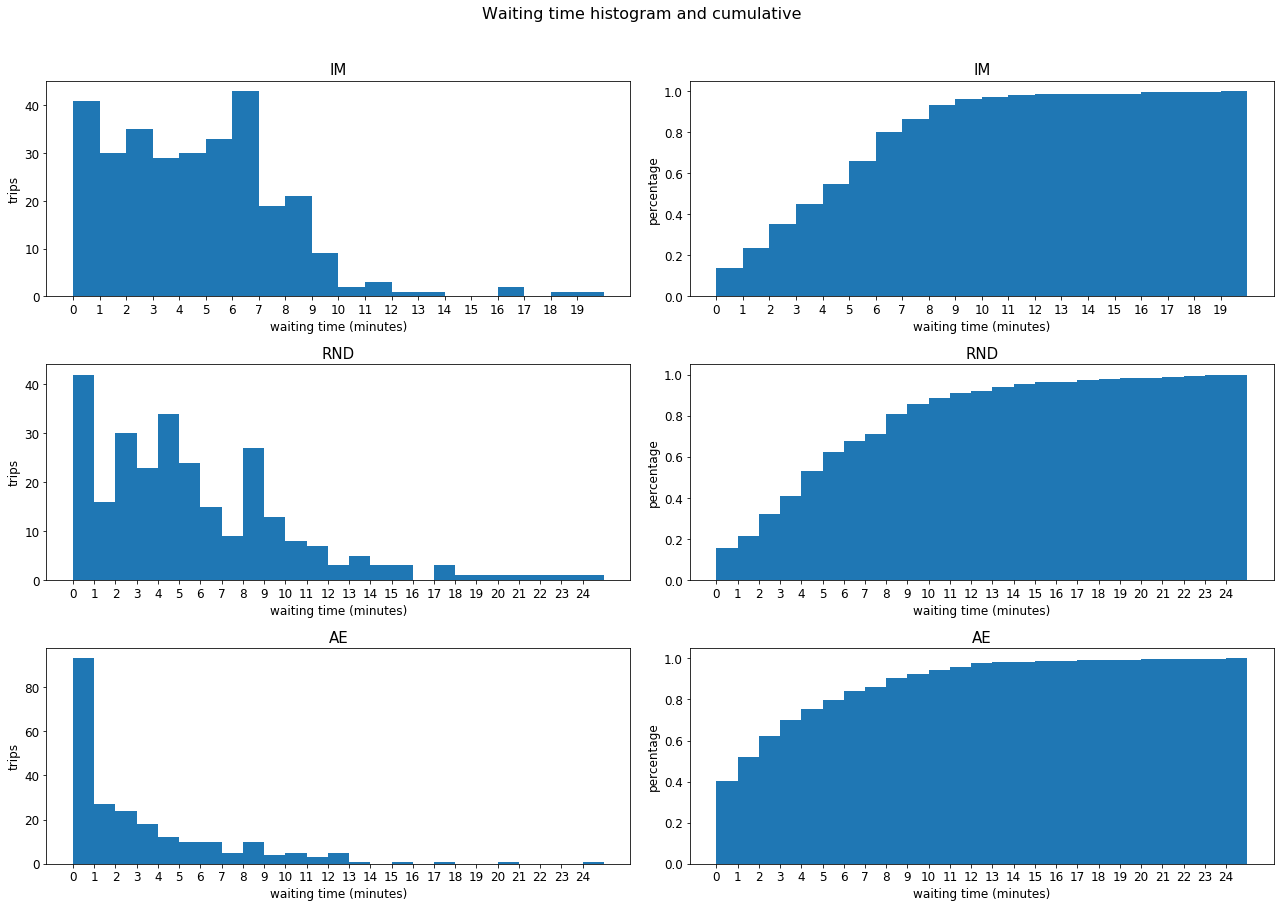

In [194]:
histogram(solutions, solutions_method, points_1200_1400_mapped)

display results (wait per point bar)

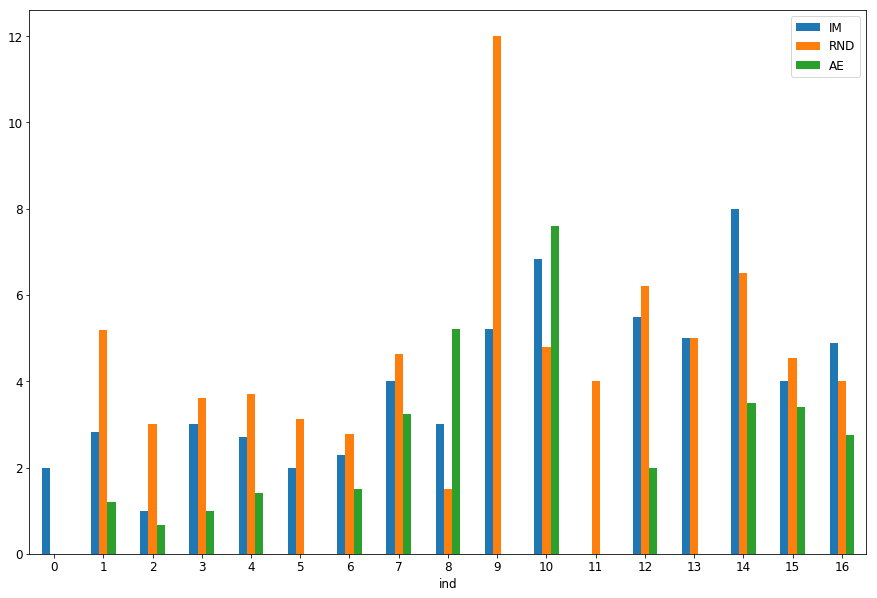

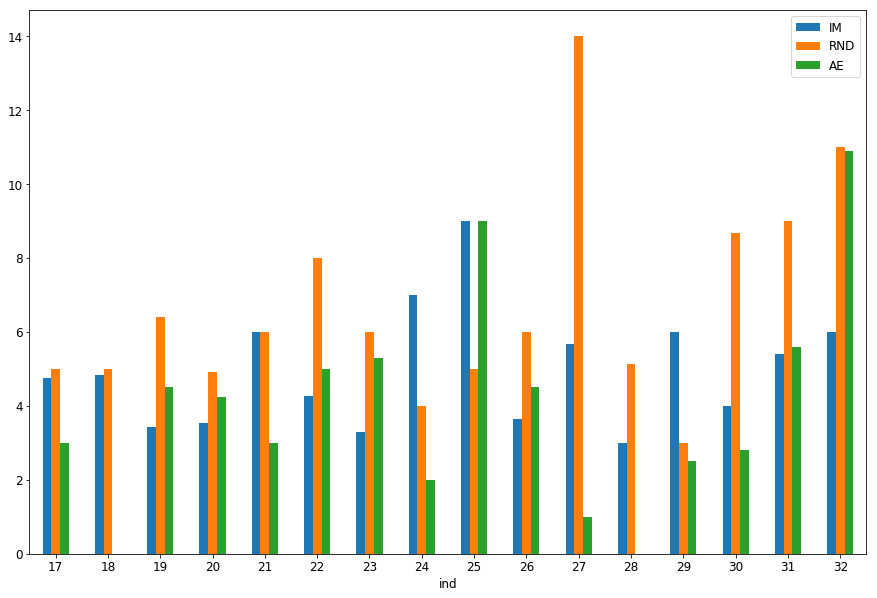

In [195]:
bars(solutions, solutions_method, points_1200_1400_mapped)

plotting scenarios

/home/jon/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


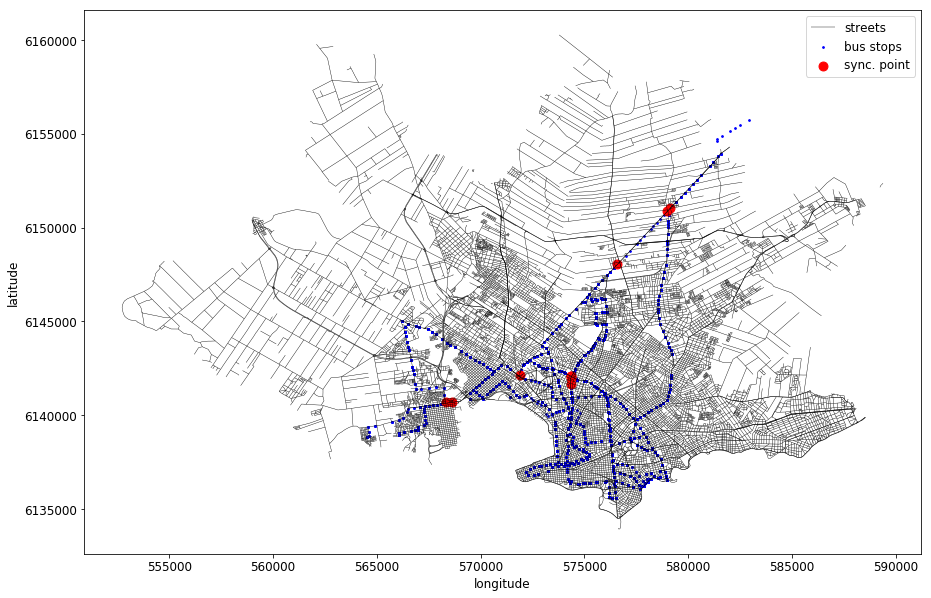

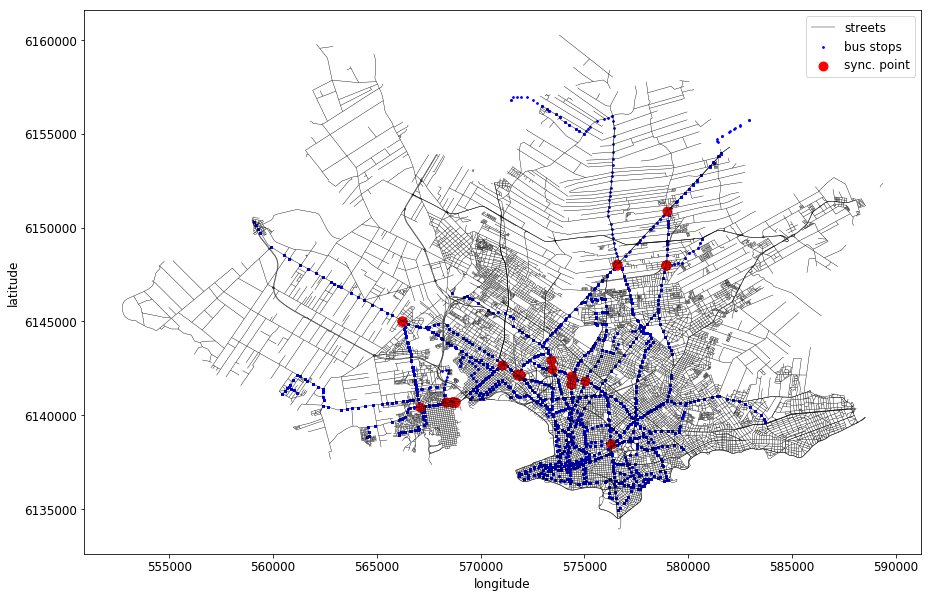

In [172]:
def plot_map(stop_coors,frequecies):
    
    for i in range(len(stop_coors)):
        gdf_bus_stops=gpd.read_file("files/v_uptu_paradas/v_uptu_paradas.shp")
        gdf_streets=gpd.read_file("files/v_mdg_vias/v_mdg_vias.shp")
        bus_schedules_by_stops_aux = bus_schedules_by_stops.copy()
        bus_schedules_by_stops_aux = bus_schedules_by_stops_aux.groupby(['cod_variante','cod_ubic_parada'], 
                                                                        sort=False).max().reset_index()
        bus_schedules_by_stops_aux = pd.merge(bus_schedules_by_stops_aux, frequecies[i], 
                         how='right', left_on=['cod_variante'], right_on=['linea'])
       
        gdf_bus_stops = pd.merge(gdf_bus_stops, bus_schedules_by_stops_aux, 
                         how='right', left_on=['COD_UBIC_P'], right_on=['cod_ubic_parada'])
        geometry = stop_coors[i]['line_1_geometry']
        crs = {'init': 'epsg:4326'}
        syncs1 = gpd.GeoDataFrame(stop_coors, crs=crs, geometry=geometry)
        geometry = stop_coors[i]['line_2_geometry']
        crs = {'init': 'epsg:4326'}
        syncs2 = gpd.GeoDataFrame(stop_coors[i], crs=crs, geometry=geometry)
        fig, ax = plt.subplots(figsize=(15, 10))
        gdf_streets.plot(ax=ax,
                        linewidth=0.4,
                        color="black",
                        label="streets")
        gdf_bus_stops.plot(ax=ax,
                           color="blue",
                        markersize=3,
                      label="bus stops")

        syncs = syncs1.append(syncs2)

        syncs.plot(ax=ax,
                           color="red",
                        markersize=80,
                      label="sync. point")

        plt.legend()
        plt.xlabel("longitude")
        plt.ylabel("latitude")
        plt.rcParams.update({'font.size': 12})

        plt.savefig("figs/paradas_buses.png", bbox_inches='tight')

stop_coors = [
    transfers_all_day_max_tts_coors, 
    transfers_1200_1400_max_tts_coors]

frequecies = [
    frequencies_all_day, 
    frequencies_1200_1400]

plot_map(stop_coors,frequecies)
